# Getting necessary libraries`

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Loading the dataset and splitting the dataset

In [4]:
batch_size = 32 #creating the dataset with this batch
image_height = 224 #loading all the images with this height
image_width = 224 #loading all the images with this width
seed = 42 #by doing this data doesn't change order after the shuffle

train_images = 'Image Training Data'
test_images = 'Image Test Data'

# Creating a training dataset
train_data = tf.keras.utils.image_dataset_from_directory(
    directory=train_images,
    label_mode='categorical',
    seed=seed,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    validation_split=0.2,  #images for validation
    subset="training",  # Specify this is the training subset
    shuffle=True  # Shuffle the training dataset 
)

# Creating a validation dataset
valid_data = tf.keras.utils.image_dataset_from_directory(
    directory=train_images,
    label_mode='categorical',
    seed=seed,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    validation_split=0.2,  #images for validation
    subset="validation",  # Specify this is the validation subset
    shuffle=True  # shuffle validation data
)

#creating test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    directory=test_images,
    label_mode='categorical',
    batch_size=batch_size,
    seed = seed,
    image_size=(image_height, image_width),
    shuffle = False)

class_labels = train_data.class_names #saving all the class names
print(class_labels)
class_num = len(class_labels) #saving the class numbers
print(f"number of class = {class_num}")

Found 2223 files belonging to 19 classes.
Using 1779 files for training.
Found 2223 files belonging to 19 classes.
Using 444 files for validation.
Found 570 files belonging to 19 classes.
['Adult', 'Airplane', 'Alpaca', 'Bird', 'Bus', 'Car', 'Cat', 'Child', 'Dog', 'Elephant', 'Flower', 'Giraffe', 'Horse', 'Monkey', 'Panda', 'Reptile', 'Train', 'Vessel', 'Zebra']
number of class = 19


# Printing some images as examples

2025-08-20 15:50:13.091514: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


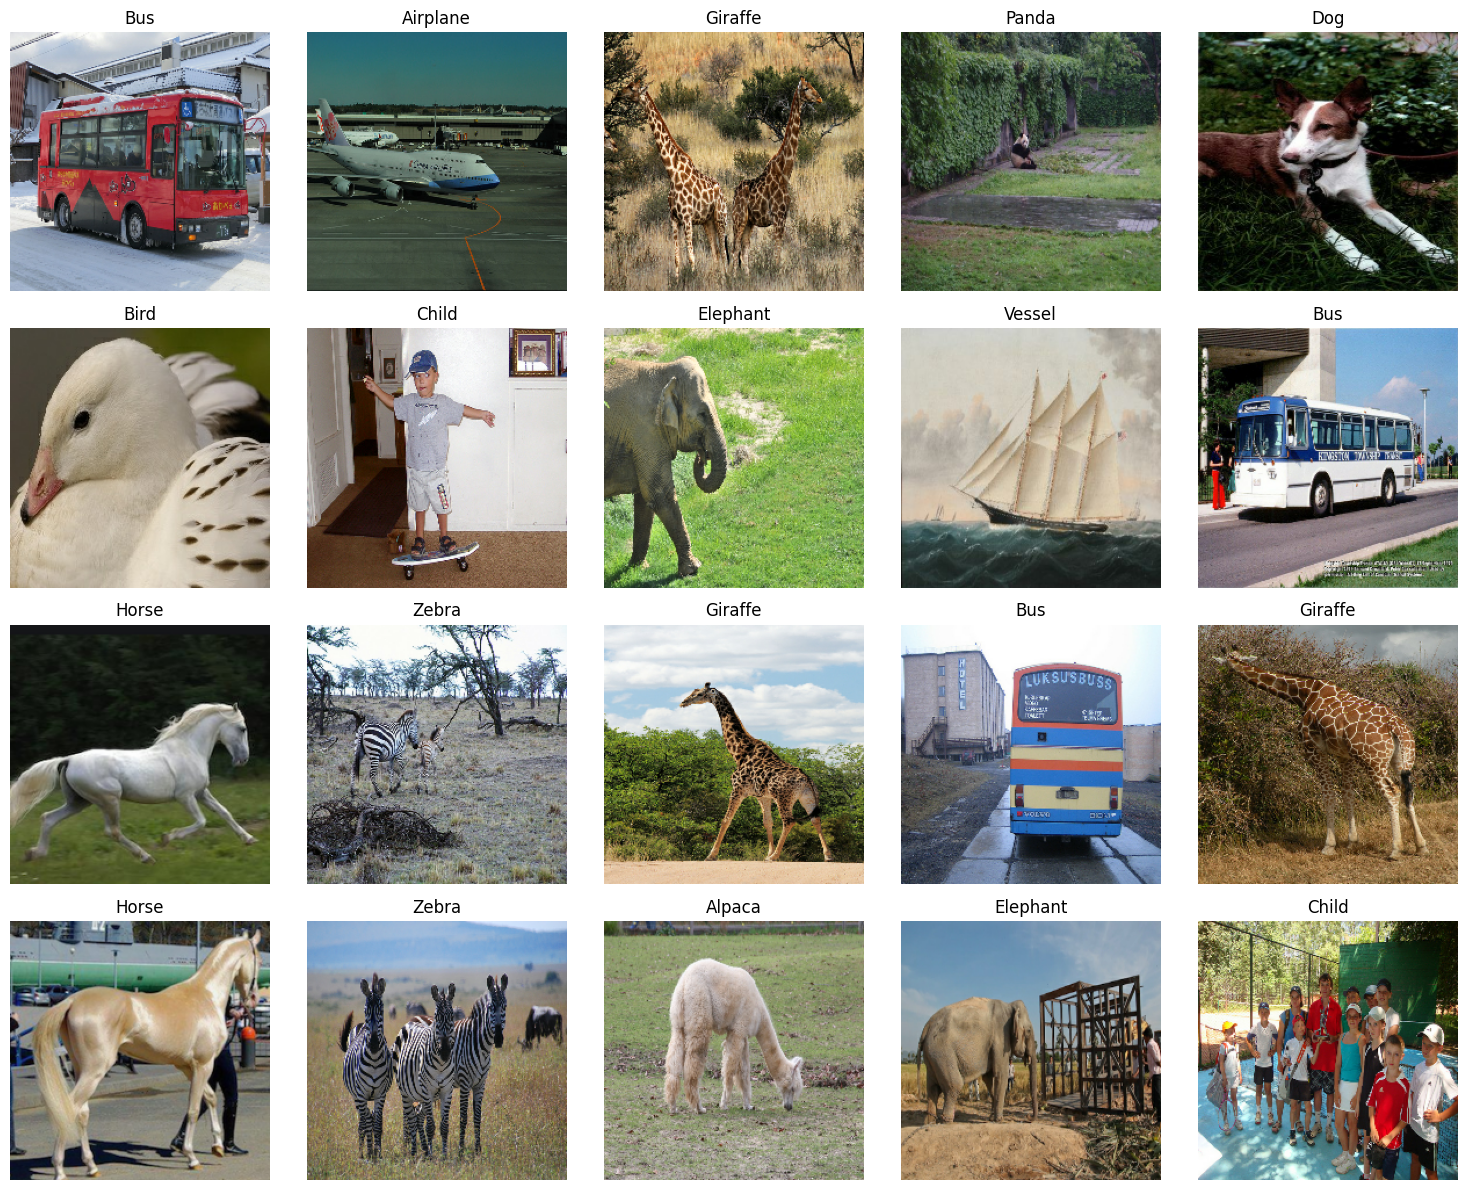

In [5]:
def plot_images(data, class_names, image_num):
    cols = 5
    rows = int(np.ceil(image_num / cols))

    plt.figure(figsize=(3 * cols, 3 * rows))

    # Take one batch from the dataset
    for images, label_idxs in data.take(1):
        for i in range(image_num):
            ax = plt.subplot(rows, cols, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = class_names[np.argmax(label_idxs[i].numpy())]
            plt.title(f"{label}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_images(train_data,class_labels,20) #printing 4 images

# Normalizing the data

In [6]:
def normalize_data(image, label):
    return image / 255.0, label  # Normalize pixel values to [0, 1]

train_data = train_data.map(normalize_data) #passing train data and saving normalized value
valid_data = valid_data.map(normalize_data) #passing validation data and saving normalized value
print(train_data)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None))>


# Designing the classifier model layer combining VGG16's pre trained weights

In [7]:
from tensorflow.keras import models
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
trained_model = VGG16(weights="imagenet", include_top=False, input_shape=(image_height,image_width,3))
trained_model.trainable = False ## Not trainable weights

classifier_vgg = models.Sequential([
    trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(19, activation='softmax')])

classifier_vgg.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
classifier_vgg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │         9,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,570,003 (105.17 MB)

 Trainable params: 12,855,315 (49.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Training the above designed model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,  
    patience=3,
    verbose=1,  
    mode='max',  
    restore_best_weights=True  
)


history = classifier_vgg.fit(train_data,epochs=10,validation_data=valid_data,callbacks=[early_stopping])

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.2451 - loss: 2.5166 - val_accuracy: 0.4347 - val_loss: 1.8964
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.5913 - loss: 1.3853 - val_accuracy: 0.6036 - val_loss: 1.3502
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.7386 - loss: 0.9200 - val_accuracy: 0.6486 - val_loss: 1.1103
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.8117 - loss: 0.6916 - val_accuracy: 0.6959 - val_loss: 0.9749
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.8696 - loss: 0.5376 - val_accuracy: 0.7005 - val_loss: 0.8984
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.8909 - loss: 0.4487 - val_accuracy: 0.6937 - val_loss: 0.9554
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.9219 - loss: 0.3815 - val_accuracy: 0.7005 - val_loss: 0.8944
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.9494 - loss: 0.2997 - val_accuracy: 0.7140 - v

# Predicting the classes

In [10]:
test_data = test_data.map(normalize_data) #passing test data and saving normalized value
predicted_images = classifier_vgg.predict(test_data) #getting the predicted output for test data
predicted_classes = np.argmax(predicted_images, axis=1) #converting the one hot encoded labels to numbers label as defined

18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step


# Saving the Ground truths

In [11]:
actual_classes = [] #this array will contain all the ground truth
for images, labels in test_data:
    actual_classes.extend(labels.numpy()) #getting the actual labels of test data

actual_classes = np.argmax(actual_classes, axis=1) #converting the one hot encoded labels to numbers label as defined

2025-08-20 16:26:22.711202: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Plotting the Confusion Matrix and Classification Report

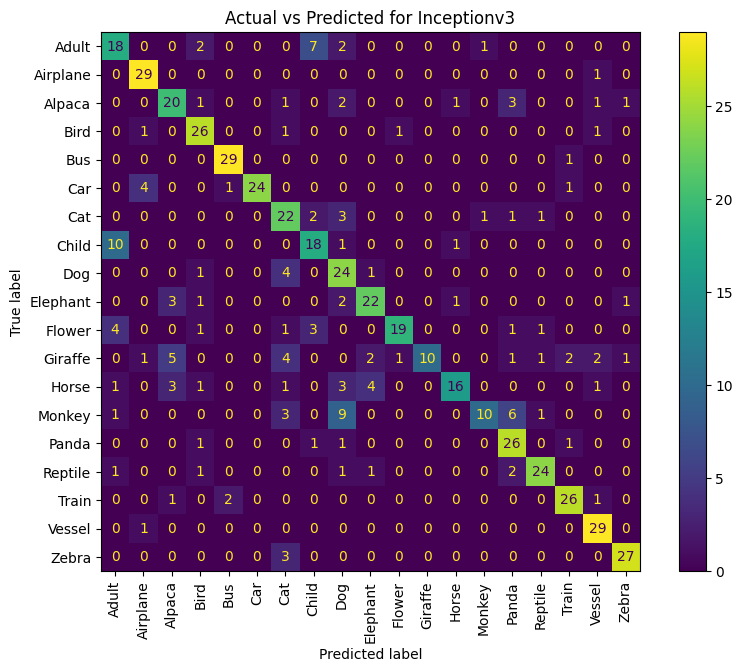

Classification Report:
               precision    recall  f1-score   support

       Adult       0.51      0.60      0.55        30
    Airplane       0.81      0.97      0.88        30
      Alpaca       0.62      0.67      0.65        30
        Bird       0.74      0.87      0.80        30
         Bus       0.91      0.97      0.94        30
         Car       1.00      0.80      0.89        30
         Cat       0.55      0.73      0.63        30
       Child       0.58      0.60      0.59        30
         Dog       0.50      0.80      0.62        30
    Elephant       0.73      0.73      0.73        30
      Flower       0.90      0.63      0.75        30
     Giraffe       1.00      0.33      0.50        30
       Horse       0.84      0.53      0.65        30
      Monkey       0.83      0.33      0.48        30
       Panda       0.65      0.87      0.74        30
     Reptile       0.86      0.80      0.83        30
       Train       0.84      0.87      0.85        30
   

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(actual_classes, predicted_classes) #generating the confusion matrix

#plotting the confusion matrix
disp=ConfusionMatrixDisplay(conf_matrix,display_labels=class_labels)
fig,ax = plt.subplots(figsize=(10,7))
disp.plot(ax=ax)
ax.set_title('Actual vs Predicted for Inceptionv3')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

#generating the classification report
class_report = classification_report(actual_classes, predicted_classes, target_names=class_labels)  # replace class_labels with your actual list of class names
print("Classification Report:\n", class_report)